# Define

In [1]:
import datajoint as dj
schema = dj.schema('university')

[2023-10-31 21:34:04,539][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-10-31 21:34:04,552][INFO]: Connected root@fakeservices.datajoint.io:3306


In [2]:
@schema
class Student(dj.Manual):
    definition = """
    student_id : int unsigned   # university-wide ID number
    ---
    first_name      : varchar(40)
    last_name       : varchar(40)
    sex             : enum('F', 'M', 'U')
    date_of_birth   : date
    home_address    : varchar(120) # mailing street address
    home_city       : varchar(60)  # mailing address
    home_state      : char(2)      # US state acronym: e.g. OH
    home_zip        : char(10)     # zipcode e.g. 93979-4979
    home_phone      : varchar(20)  # e.g. 414.657.6883x0881
    """

In [3]:
@schema
class Department(dj.Manual):
    definition = """
    dept : varchar(6)   # abbreviated department name, e.g. BIOL
    ---
    dept_name    : varchar(200)  # full department name
    dept_address : varchar(200)  # mailing address
    dept_phone   : varchar(20)
    """

In [4]:
@schema
class StudentMajor(dj.Manual):
    definition = """
    -> Student
    ---
    -> Department
    declare_date :  date  # when student declared her major
    """

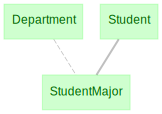

In [5]:
dj.Diagram(schema)

In [6]:
@schema
class Course(dj.Manual):
    definition = """
    -> Department
    course  : int unsigned   # course number, e.g. 1010
    ---
    course_name :  varchar(200)  # e.g. "Neurobiology of Sensation and Movement."
    credits     :  decimal(3,1)  # number of credits earned by completing the course
    """
    
@schema
class Term(dj.Manual):
    definition = """
    term_year : year
    term      : enum('Spring', 'Summer', 'Fall')
    """

@schema
class Section(dj.Manual):
    definition = """
    -> Course
    -> Term
    section : char(1)
    ---
    auditorium   :  varchar(12)
    """
    
@schema
class CurrentTerm(dj.Manual):
    definition = """
    -> Term
    """

@schema
class Enroll(dj.Manual):
    definition = """
    -> Student
    -> Section
    """

@schema
class LetterGrade(dj.Manual):
    definition = """
    grade : char(2)
    ---
    points : decimal(3,2)
    """

@schema
class Grade(dj.Manual):
    definition = """
    -> Enroll
    ---
    -> LetterGrade
    """

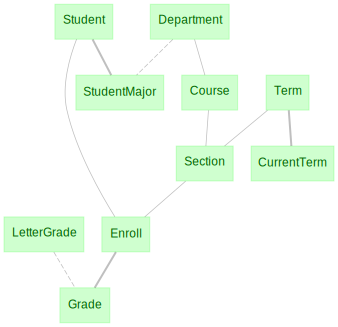

In [7]:
dj.Diagram(schema)

In [8]:
from tqdm import tqdm
import faker
import random
import itertools
import datetime
fake = faker.Faker()

In [9]:
def yield_students():
    fake_name = {'F': fake.name_female, 'M': fake.name_male}
    while True:  # ignore invalid values
        try:
            sex = random.choice(('F', 'M'))
            first_name, last_name = fake_name[sex]().split(' ')[:2]
            street_address, city = fake.address().split('\n')
            city, state = city.split(', ')
            state, zipcode = state.split(' ')            
        except ValueError:
            continue
        else:
            yield dict(
                first_name=first_name,
                last_name=last_name,
                sex=sex,
                home_address=street_address,
                home_city=city,
                home_state=state,
                home_zip=zipcode,
                date_of_birth=str(
                    fake.date_time_between(start_date="-35y", end_date="-15y").date()),
                home_phone = fake.phone_number()[:20])

In [10]:
Student.insert(
    dict(k, student_id=i) for i, k in zip(range(100,300), yield_students()))

In [11]:
Student()

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Jordan,Roy,F,2003-01-26,328 Saunders Avenue,West Susanland,MI,25478,6826309566
101,Luis,Griffin,M,1991-11-19,777 Kristin Stream,Port Timothy,NM,26753,+1-573-927-1122x7498
102,Rhonda,Melton,F,1991-02-28,54424 Michael Flat,West Richard,PW,35557,270.612.6710
103,Rebecca,Rogers,F,2007-01-19,67607 Scott Motorway,Jasmineborough,ME,72148,+1-381-336-9496x243
104,Bobby,Morgan,M,2000-08-03,546 Rodriguez Vista Suite 121,New Karentown,TX,42320,+1-754-585-3248x282
105,Jennifer,Mitchell,F,1992-11-04,2424 Philip Crest,Johnsonport,MS,16129,264.221.2688
106,Angela,Gordon,F,1998-10-21,119 John Cove Apt. 577,Barbermouth,NC,87356,+1-939-793-8944x442
107,Bradley,Henry,M,2001-03-09,2259 Klein Mountains,New John,VT,95089,8866328779
108,Katrina,Bennett,F,2003-08-07,8486 Padilla Curve,Port Michael,IA,95792,+1-403-246-0298x8785
109,Keith,Gates,M,1995-08-03,2909 Barker Overpass Suite 314,East Jeremy,UT,29772,743-717-2292x03200


In [12]:
Department.insert(
    dict(dept=dept, 
         dept_name=name, 
         dept_address=fake.address(), 
         dept_phone=fake.phone_number()[:20])
    for dept, name in [
        ["CS", "Computer Science"],
        ["BIOL", "Life Sciences"],
        ["PHYS", "Physics"],
        ["MATH", "Mathematics"]])

In [13]:
StudentMajor.insert({**s, **d, 
                     'declare_date':fake.date_between(start_date=datetime.date(1999,1,1))}
    for s, d in zip(Student.fetch('KEY'), random.choices(Department.fetch('KEY'), k=len(Student())))
                   if random.random() < 0.75)

In [14]:
StudentMajor()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL",declare_date when student declared her major
100,MATH,2010-12-15
102,BIOL,2020-04-28
103,MATH,2003-02-25
104,MATH,2018-02-09
105,BIOL,2018-08-21
106,PHYS,2016-03-05
108,BIOL,2018-07-28
109,PHYS,2006-07-16
110,PHYS,2016-11-27
112,BIOL,2008-05-20


In [15]:
# from https://www.utah.edu/
Course.insert([
    ['BIOL', 1006, 'World of Dinosaurs', 3],
    ['BIOL', 1010, 'Biology in the 21st Century', 3],
    ['BIOL', 1030, 'Human Biology', 3],
    ['BIOL', 1210, 'Principles of Biology', 4],
    ['BIOL', 2010, 'Evolution & Diversity of Life', 3],
    ['BIOL', 2020, 'Principles of Cell Biology',  3],
    ['BIOL', 2021, 'Principles of Cell Science',  4],
    ['BIOL', 2030, 'Principles of Genetics',  3],
    ['BIOL', 2210, 'Human Genetics',3],
    ['BIOL', 2325, 'Human Anatomy', 4],
    ['BIOL', 2330, 'Plants & Society', 3],
    ['BIOL', 2355, 'Field Botany', 2],
    ['BIOL', 2420, 'Human Physiology', 4],

    ['PHYS', 2040, 'Classcal Theoretical Physics II', 4],
    ['PHYS', 2060, 'Quantum Mechanics', 3],
    ['PHYS', 2100, 'General Relativity and Cosmology', 3],
    ['PHYS', 2140, 'Statistical Mechanics', 4],
    
    ['PHYS', 2210, 'Physics for Scientists and Engineers I', 4], 
    ['PHYS', 2220, 'Physics for Scientists and Engineers II', 4],
    ['PHYS', 3210, 'Physics for Scientists I (Honors)', 4],
    ['PHYS', 3220, 'Physics for Scientists II (Honors)', 4],
    
    ['MATH', 1250, 'Calculus for AP Students I', 4],
    ['MATH', 1260, 'Calculus for AP Students II', 4],
    ['MATH', 1210, 'Calculus I', 4],
    ['MATH', 1220, 'Calculus II', 4],
    ['MATH', 2210, 'Calculus III', 3],
 
    ['MATH', 2270, 'Linear Algebra', 4],
    ['MATH', 2280, 'Introduction to Differential Equations', 4],
    ['MATH', 3210, 'Foundations of Analysis I', 4],
    ['MATH', 3220, 'Foundations of Analysis II', 4],
    
    ['CS', 1030, 'Foundations of Computer Science', 3],
    ['CS', 1410, 'Introduction to Object-Oriented Programming', 4],
    ['CS', 2420, 'Introduction to Algorithms & Data Structures', 4],
    ['CS', 2100, 'Discrete Structures', 3],
    ['CS', 3500, 'Software Practice', 4],
    ['CS', 3505, 'Software Practice II', 3],
    ['CS', 3810, 'Computer Organization', 4],
    ['CS', 4400, 'Computer Systems', 4],
    ['CS', 4150, 'Algorithms', 3],
    ['CS', 3100, 'Models of Computation', 3],
    ['CS', 3200, 'Introduction to Scientific Computing', 3],
    ['CS', 4000, 'Senior Capstone Project - Design Phase', 3],
    ['CS', 4500, 'Senior Capstone Project', 3],
    ['CS', 4940, 'Undergraduate Research', 3],
    ['CS', 4970, 'Computer Science Bachelor''s Thesis', 3]])

In [16]:
Term.insert(dict(term_year=year, term=term) 
            for year in range(1999, 2019) 
            for term in ['Spring', 'Summer', 'Fall'])

Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]

CurrentTerm().insert1({
    **Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]})

def make_section(prob):
    for c in (Course * Term).proj():
        for sec in 'abcd':
            if random.random() < prob:
                break
            yield {
                **c, 'section': sec, 
                'auditorium': random.choice('ABCDEF') + str(random.randint(1,100))}   

Section.insert(make_section(0.5))

In [17]:
LetterGrade.insert([
    ['A',  4.00],
    ['A-', 3.67],
    ['B+', 3.33],
    ['B',  3.00],
    ['B-', 2.67],
    ['C+', 2.33],
    ['C',  2.00],
    ['C-', 1.67],
    ['D+', 1.33],
    ['D',  1.00],
    ['F',  0.00]])

In [18]:
LetterGrade()

grade,points
A,4.00
A-,3.67
B,3.00
B-,2.67
B+,3.33
C,2.00
C-,1.67
C+,2.33
D,1.00
D+,1.33


In [19]:
# Enrollment 
terms = Term().fetch('KEY')
quit_prob = 0.1
for student in tqdm(Student.fetch('KEY')):
    start_term = random.randrange(len(terms))
    for term in terms[start_term:]:
        if random.random() < quit_prob:
            break
        else:
            sections = ((Section & term) - (Course & (Enroll & student))).fetch('KEY')
            if sections:
                Enroll.insert({**student, **section} for section in 
                              random.sample(sections, random.randrange(min(5, len(sections)))))

100%|██████████| 200/200 [00:40<00:00,  4.96it/s]


In [20]:
# assign random grades
grades = LetterGrade.fetch('grade')

grade_keys = Enroll.fetch('KEY')
random.shuffle(grade_keys)
grade_keys = grade_keys[:len(grade_keys)*9//10]

Grade.insert({**key, 'grade':grade} 
             for key, grade in zip(grade_keys, random.choices(grades, k=len(grade_keys))))

# Queries

## Restriction

In [21]:
# Students from Texas
Student & {'home_state': 'TX'}

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
104,Bobby,Morgan,M,2000-08-03,546 Rodriguez Vista Suite 121,New Karentown,TX,42320,+1-754-585-3248x282
151,Christopher,Jackson,M,1997-11-30,1344 Willis Crest,Mathewsshire,TX,02380,373-329-0653x45425
154,Kathryn,Williams,F,1997-05-25,252 Wanda Harbors,Roblestown,TX,74304,752-407-8170x7030
205,Kimberly,Johnson,F,2008-03-09,7814 Brian Plaza,West Nicole,TX,27816,248-366-8432x9592


In [22]:
Student & 'home_state="TX"'

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
104,Bobby,Morgan,M,2000-08-03,546 Rodriguez Vista Suite 121,New Karentown,TX,42320,+1-754-585-3248x282
151,Christopher,Jackson,M,1997-11-30,1344 Willis Crest,Mathewsshire,TX,02380,373-329-0653x45425
154,Kathryn,Williams,F,1997-05-25,252 Wanda Harbors,Roblestown,TX,74304,752-407-8170x7030
205,Kimberly,Johnson,F,2008-03-09,7814 Brian Plaza,West Nicole,TX,27816,248-366-8432x9592


In [23]:
# Male students from outside Texas
(Student & 'sex="M"') - {'home_state': 'TX'}

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
101,Luis,Griffin,M,1991-11-19,777 Kristin Stream,Port Timothy,NM,26753,+1-573-927-1122x7498
107,Bradley,Henry,M,2001-03-09,2259 Klein Mountains,New John,VT,95089,8866328779
109,Keith,Gates,M,1995-08-03,2909 Barker Overpass Suite 314,East Jeremy,UT,29772,743-717-2292x03200
115,Gregg,Martinez,M,1999-11-02,4550 Torres Via Suite 368,New Peter,WA,25601,805-497-3473x8655
116,Darrell,Williams,M,2001-04-16,8310 Tyler Mountain Suite 130,New Christian,SC,37869,001-391-364-6711
117,Andrew,Hoover,M,1994-10-30,0147 Miles Tunnel,Lake Jennifer,FM,73910,001-889-404-7668x714
119,Jeremy,Jones,M,2006-07-20,07975 Adams Viaduct Apt. 921,Ericksonshire,WA,78996,914.524.1366
120,Andrew,Kelly,M,2003-09-04,6991 Martinez Grove Apt. 504,Greerbury,MI,20913,(894)650-2939x52028
121,Shannon,Campbell,M,2006-09-20,7399 James Valley Apt. 637,Jensenview,PA,38660,(525)740-8550
122,Jason,Hudson,M,1999-06-27,61276 Hines Wells,Melanieview,MI,67378,+1-894-564-3945x069


In [24]:
# Students from TX, OK, or NM
Student & [{'home_state':'OK'}, {'home_state':'NM'}, {'home_state':'TX'}] 

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
101,Luis,Griffin,M,1991-11-19,777 Kristin Stream,Port Timothy,NM,26753,+1-573-927-1122x7498
104,Bobby,Morgan,M,2000-08-03,546 Rodriguez Vista Suite 121,New Karentown,TX,42320,+1-754-585-3248x282
151,Christopher,Jackson,M,1997-11-30,1344 Willis Crest,Mathewsshire,TX,02380,373-329-0653x45425
152,Gary,Kelley,M,2006-08-18,468 Latoya Trail,Jameston,NM,74191,225-953-0926
154,Kathryn,Williams,F,1997-05-25,252 Wanda Harbors,Roblestown,TX,74304,752-407-8170x7030
182,Matthew,Garcia,M,1996-04-28,222 Becker Shoals,Sanchezshire,OK,71879,001-238-556-4867
205,Kimberly,Johnson,F,2008-03-09,7814 Brian Plaza,West Nicole,TX,27816,248-366-8432x9592
211,David,Robinson,M,1990-02-18,02562 Stephanie Groves Suite 222,Oconnorfurt,NM,06795,(792)937-7966x38758
214,Nicole,Reynolds,F,2003-02-07,5758 Robert Land,Lake Travis,OK,65089,600-895-2572x051
223,Michael,Weber,M,1990-10-31,8285 Ramirez Pines Suite 214,Terrimouth,OK,55298,+1-355-488-7233x224


In [25]:
# Millenials
millennials = Student & 'date_of_birth between "1981-01-01" and "1996-12-31"'

In [26]:
millennials

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
101,Luis,Griffin,M,1991-11-19,777 Kristin Stream,Port Timothy,NM,26753,+1-573-927-1122x7498
102,Rhonda,Melton,F,1991-02-28,54424 Michael Flat,West Richard,PW,35557,270.612.6710
105,Jennifer,Mitchell,F,1992-11-04,2424 Philip Crest,Johnsonport,MS,16129,264.221.2688
109,Keith,Gates,M,1995-08-03,2909 Barker Overpass Suite 314,East Jeremy,UT,29772,743-717-2292x03200
111,Catherine,Moses,F,1996-08-11,37827 Carolyn Wells,Williamsonchester,NC,97844,716.464.4008x2146
113,Karen,Daniel,F,1996-05-21,92322 Bailey Valleys Apt. 263,Wendyberg,KS,55048,+1-236-576-8707x878
117,Andrew,Hoover,M,1994-10-30,0147 Miles Tunnel,Lake Jennifer,FM,73910,001-889-404-7668x714
124,Brianna,Jones,F,1994-02-19,640 Boyd Parkways,Crystalmouth,ID,59060,(644)384-4085x9816
127,Danielle,Gould,F,1996-08-11,972 George Prairie,Deniseport,NJ,27306,615-935-9425x0807
130,Raymond,Martinez,M,1996-09-13,77927 Ethan Row Suite 800,Fieldsberg,GA,97279,8698203619


In [27]:
# Students who have taken classes
Student & Enroll

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Jordan,Roy,F,2003-01-26,328 Saunders Avenue,West Susanland,MI,25478,6826309566
101,Luis,Griffin,M,1991-11-19,777 Kristin Stream,Port Timothy,NM,26753,+1-573-927-1122x7498
102,Rhonda,Melton,F,1991-02-28,54424 Michael Flat,West Richard,PW,35557,270.612.6710
103,Rebecca,Rogers,F,2007-01-19,67607 Scott Motorway,Jasmineborough,ME,72148,+1-381-336-9496x243
105,Jennifer,Mitchell,F,1992-11-04,2424 Philip Crest,Johnsonport,MS,16129,264.221.2688
106,Angela,Gordon,F,1998-10-21,119 John Cove Apt. 577,Barbermouth,NC,87356,+1-939-793-8944x442
107,Bradley,Henry,M,2001-03-09,2259 Klein Mountains,New John,VT,95089,8866328779
108,Katrina,Bennett,F,2003-08-07,8486 Padilla Curve,Port Michael,IA,95792,+1-403-246-0298x8785
109,Keith,Gates,M,1995-08-03,2909 Barker Overpass Suite 314,East Jeremy,UT,29772,743-717-2292x03200
110,Destiny,Benjamin,F,2005-04-15,81809 Richards Squares,Gregorymouth,OR,57886,+1-366-248-6065x208


In [28]:
# Millenials who have never enrolled
millennials - Enroll

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
159,Gary,Bell,M,1990-04-12,12358 Orr Spring Apt. 648,Jenniferside,PW,72056,+1-210-213-1590x503
164,Michael,Campbell,M,1988-11-11,000 Gonzalez Ville,Harrisstad,NJ,94771,609-661-1877
165,Donna,Valdez,F,1990-12-31,15800 Clark Branch Suite 089,Smithport,PR,70502,207.249.7876x43833
200,Ryan,Butler,M,1990-12-07,53510 Schaefer Crest Apt. 831,West Brianview,KY,37100,662.488.5373
212,Marie,Jensen,F,1994-06-20,2176 Lori Ferry,Johnborough,VT,08649,712.471.0726x5033
217,Travis,Burns,M,1992-07-14,574 Mccoy Passage Apt. 671,West Johnhaven,MS,45598,(434)616-9677x203
228,Angela,Miller,F,1989-04-15,53016 Miller Fort Apt. 962,Lake Stacy,NE,23528,570-682-8086
236,Brady,Hayes,M,1993-04-13,946 Kevin Creek,North Markborough,IN,87319,(920)655-5330
296,Edward,Reilly,M,1995-09-21,398 Davis Turnpike,Leeburgh,PW,66797,729-815-6617


In [29]:
# Students who have not taken classes
Student - Enroll

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
104,Bobby,Morgan,M,2000-08-03,546 Rodriguez Vista Suite 121,New Karentown,TX,42320,+1-754-585-3248x282
115,Gregg,Martinez,M,1999-11-02,4550 Torres Via Suite 368,New Peter,WA,25601,805-497-3473x8655
119,Jeremy,Jones,M,2006-07-20,07975 Adams Viaduct Apt. 921,Ericksonshire,WA,78996,914.524.1366
121,Shannon,Campbell,M,2006-09-20,7399 James Valley Apt. 637,Jensenview,PA,38660,(525)740-8550
134,Christopher,Garcia,M,2001-09-18,246 Breanna Forges Suite 371,Webbbury,IN,98054,(862)872-7013
141,Michael,Mitchell,M,2006-10-12,61423 Hunter Dam,North Joshua,MS,78973,(555)481-4418x3517
155,Adam,Glover,M,2007-04-23,201 Sydney Points Suite 756,Lake Antonio,PR,78259,(857)204-3851x8670
159,Gary,Bell,M,1990-04-12,12358 Orr Spring Apt. 648,Jenniferside,PW,72056,+1-210-213-1590x503
164,Michael,Campbell,M,1988-11-11,000 Gonzalez Ville,Harrisstad,NJ,94771,609-661-1877
165,Donna,Valdez,F,1990-12-31,15800 Clark Branch Suite 089,Smithport,PR,70502,207.249.7876x43833


In [30]:
# Students who have taken Biology classes but no MATH courses
(Student & (Enroll & 'dept="BIOL"')) - (Enroll & 'dept="MATH"')

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
131,Regina,Stevens,F,2008-03-28,5535 Monica Run,New Davidfurt,FM,61403,001-642-944-8490
133,Joann,Rhodes,F,2001-11-10,7747 Ford Cape,West Andrewland,IN,26601,477-404-0830x5778
150,Carl,Hernandez,M,2001-05-31,395 Maria Alley,North Virginiatown,OH,05388,513.264.5124x544
152,Gary,Kelley,M,2006-08-18,468 Latoya Trail,Jameston,NM,74191,225-953-0926
161,Patricia,Williams,F,1991-08-25,859 John Cove,Rodriguezborough,IL,43598,5127074752
163,Gabriel,Hamilton,M,2002-02-01,071 Carson Union,New Thomas,GA,86656,(486)759-7442x320
213,Gregory,Farley,M,1989-03-30,472 Ashlee Circles,North Saramouth,WA,68135,755.273.4453
215,Jon,Mora,M,1996-12-23,38159 Mary Place,Ashleyfurt,PA,21276,+1-291-400-4627x0887
221,Kenneth,Sims,M,2005-09-22,97810 Andrea Locks,Port Loribury,IA,19088,505.239.9379x51533
223,Michael,Weber,M,1990-10-31,8285 Ramirez Pines Suite 214,Terrimouth,OK,55298,+1-355-488-7233x224


In [31]:
# Students who have not selected a major
Student - StudentMajor

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
101,Luis,Griffin,M,1991-11-19,777 Kristin Stream,Port Timothy,NM,26753,+1-573-927-1122x7498
107,Bradley,Henry,M,2001-03-09,2259 Klein Mountains,New John,VT,95089,8866328779
111,Catherine,Moses,F,1996-08-11,37827 Carolyn Wells,Williamsonchester,NC,97844,716.464.4008x2146
118,Stephanie,Bernard,F,2007-04-30,6929 Laura Branch,Paynechester,NJ,98729,2292643896
120,Andrew,Kelly,M,2003-09-04,6991 Martinez Grove Apt. 504,Greerbury,MI,20913,(894)650-2939x52028
122,Jason,Hudson,M,1999-06-27,61276 Hines Wells,Melanieview,MI,67378,+1-894-564-3945x069
124,Brianna,Jones,F,1994-02-19,640 Boyd Parkways,Crystalmouth,ID,59060,(644)384-4085x9816
128,Steven,Sutton,M,2005-11-11,46410 Dale Tunnel Apt. 352,South Samanthaton,TN,71881,801.205.8852x7765
130,Raymond,Martinez,M,1996-09-13,77927 Ethan Row Suite 800,Fieldsberg,GA,97279,8698203619
139,Dawn,Carlson,F,1988-11-09,955 Woodard Centers Suite 680,Barrettmouth,MP,38164,312-762-0284


In [32]:
# Students who are taking courses in the current term
Student - (Enroll & CurrentTerm)

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Jordan,Roy,F,2003-01-26,328 Saunders Avenue,West Susanland,MI,25478,6826309566
101,Luis,Griffin,M,1991-11-19,777 Kristin Stream,Port Timothy,NM,26753,+1-573-927-1122x7498
102,Rhonda,Melton,F,1991-02-28,54424 Michael Flat,West Richard,PW,35557,270.612.6710
103,Rebecca,Rogers,F,2007-01-19,67607 Scott Motorway,Jasmineborough,ME,72148,+1-381-336-9496x243
104,Bobby,Morgan,M,2000-08-03,546 Rodriguez Vista Suite 121,New Karentown,TX,42320,+1-754-585-3248x282
105,Jennifer,Mitchell,F,1992-11-04,2424 Philip Crest,Johnsonport,MS,16129,264.221.2688
106,Angela,Gordon,F,1998-10-21,119 John Cove Apt. 577,Barbermouth,NC,87356,+1-939-793-8944x442
107,Bradley,Henry,M,2001-03-09,2259 Klein Mountains,New John,VT,95089,8866328779
108,Katrina,Bennett,F,2003-08-07,8486 Padilla Curve,Port Michael,IA,95792,+1-403-246-0298x8785
109,Keith,Gates,M,1995-08-03,2909 Barker Overpass Suite 314,East Jeremy,UT,29772,743-717-2292x03200


In [ ]:
# show corresponding SQL
(Student - (Enroll & CurrentTerm)).make_sql()

In [ ]:
# Ungraded courses
Enroll - Grade

In [ ]:
# Ungraded courses in the current term
(Enroll & CurrentTerm) - Grade

In [ ]:
# Students who have taken classes and have chosen a major
(Student & Enroll & StudentMajor)

In [ ]:
#Students who have taken classes or have chosen a major
Student & [Enroll, StudentMajor]

In [ ]:
# Enrollment in courses from the same department as the students' major
Enroll & StudentMajor

## Join

In [ ]:
# Grade point values
Grade * LetterGrade

In [ ]:
# Graded enrollments with complete course and student information
Student * Enroll * Course * Section * Grade * LetterGrade

In [ ]:
# Enrollment with major information
Enroll * StudentMajor.proj(major='dept')

In [ ]:
# Enrollment outside chosen major
Enroll * StudentMajor.proj(major='dept') & 'major<>dept'

In [ ]:
# Enrollment not matching major 
Enroll - StudentMajor 

In [ ]:
# Total grade points
(Course * Grade * LetterGrade).proj(total='points*credits')

## Aggr

In [ ]:
# Students in each section
Section.aggr(Enroll, n='count(*)')

In [ ]:
# Average grade in each course
Course.aggr(Grade*LetterGrade, avg_grade='avg(points)')

In [ ]:
# Fraction graded in each section
(Section.aggr(Enroll,n='count(*)') * Section.aggr(Grade, m='count(*)')).proj(
    'm','n',frac='m/n')

In [ ]:
# Student GPA
Student.aggr(Course * Grade * LetterGrade, 
             gpa='sum(points*credits)/sum(credits)')

In [ ]:
# Average GPA for each major
gpa = Student.aggr(Course * Grade * LetterGrade,
                   gpa='sum(points*credits)/sum(credits)')
Department.aggr(StudentMajor*gpa, avg_gpa='avg(gpa)')